In [ ]:
import matplotlib
%matplotlib nbagg
from matplotlib import pyplot

In [35]:
from statiskit import (linalg,
                       core,
                       pgm)

In [36]:
import math
import os

In [37]:
%reload_ext rpy2.ipython

In [38]:
if not 'K' in os.environ:
    os.environ['K'] = str(5)
K = int(os.environ.get('K'))
simulation = !jupyter nbconvert --ExecutePreprocessor.timeout=3600 --to notebook --execute sampling.ipynb --output sampling.ipynb
graph0 = pgm.read_gml(os.path.join('results', 'graph.gml'))
data = core.read_csv(os.path.join('results', 'data.csv'))
data

,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19
0,$2.55$,$0.36$,$0.55$,$-0.32$,$-0.50$,$-0.77$,$-0.01$,$0.77$,$1.08$,$0.30$
1,$1.48$,$1.18$,$-0.19$,$0.24$,$-0.09$,$-0.45$,$0.02$,$0.90$,$-0.11$,$-0.33$
2,$-1.95$,$1.86$,$-0.95$,$-1.04$,$0.56$,$-1.57$,$-0.14$,$0.30$,$0.38$,$-0.25$
3,$1.58$,$0.72$,$-0.34$,$-0.27$,$-0.05$,$-0.25$,$0.85$,$-0.32$,$0.73$,$0.08$
4,$-0.13$,$0.51$,$-0.20$,$1.31$,$-1.10$,$0.67$,$-0.71$,$0.96$,$-0.60$,$-0.20$
5,$-1.74$,$1.50$,$0.12$,$0.28$,$0.77$,$-1.29$,$0.91$,$-0.33$,$-0.28$,$1.05$
6,$1.32$,$-0.56$,$-0.43$,$1.63$,$-0.37$,$0.62$,$-1.37$,$-0.14$,$-1.33$,$0.93$
7,$2.18$,$0.53$,$-1.92$,$3.27$,$0.53$,$1.77$,$-0.71$,$-1.05$,$1.26$,$1.21$
8,$1.30$,$-1.00$,$-0.76$,$-2.20$,$-1.07$,$-0.51$,$-0.25$,$-0.18$,$0.45$,$0.89$
9,$1.03$,$0.17$,$0.47$,$-1.96$,$0.19$,$-1.03$,$-0.07$,$-0.39$,$0.40$,$0.29$


In [39]:
%%R
library(glasso)

LASSO <- function(dat,penality){
  
  d=length(dat)
  sigma <- cov(dat)
  #penalitÃŠ linÃŠaire
  if (penality == "LINEAIR")
    lamda <- seq(0.001,max(sigma),length.out = 1+d*(d+1)/2)
  #penalitÃŠ avec les val de sigma
  else 
    lamda <- c(sigma[ upper.tri(sigma,diag = FALSE) ],0.001)
  
  lamda <- sort(abs(lamda),decreasing = TRUE)
  
  ############ON TOURNE LE LASSO POUR CHAQUE LAMDA##########
  j=1
  for(i in lamda){
    
    lasso.res  <- glasso(sigma,rho =i)
    write.table(lasso.res$wi, paste("lasso_", j, ".csv", sep=''), row.names=FALSE,col.names = FALSE, sep =" ")
    j=j+1
  }
}

In [40]:
if not 'LASSO' in os.environ:
    os.environ['LASSO'] = "AUTRE"
LAMBDA = os.environ.get('LASSO')
LAMBDA

'AUTRE'

In [41]:
%R data = read.csv('results/data.csv', header = F, sep="") 
%R print(data)
%R LASSO(data, Sys.getenv(c("LASSO"))[1])

           V1         V2         V3         V4          V5         V6
1   2.5589088  0.3653197  0.5509884 -0.3241324 -0.50812385 -0.7738348
2   1.4856031  1.1833236 -0.1933229  0.2422025 -0.09754712 -0.4507524
3  -1.9519595  1.8626968 -0.9599796 -1.0459583  0.56410442 -1.5769052
4   1.5840357  0.7273997 -0.3472348 -0.2710934 -0.05642601 -0.2576306
5  -0.1395155  0.5179443 -0.2048027  1.3157721 -1.10387297  0.6780572
6  -1.7444839  1.5096829  0.1293095  0.2879875  0.77854941 -1.2925628
7   1.3230687 -0.5633346 -0.4355857  1.6373233 -0.37274812  0.6268771
8   2.1877617  0.5387974 -1.9252364  3.2741671  0.53803933  1.7729251
9   1.3021034 -1.0009635 -0.7630159 -2.2000538 -1.07886051 -0.5137577
10  1.0367444  0.1701158  0.4750244 -1.9664658  0.19534536 -1.0323394
            V7         V8         V9         V10
1  -0.01745721  0.7703990  1.0860583  0.30345405
2   0.02676615  0.9003851 -0.1134637 -0.33117711
3  -0.14841179  0.3054234  0.3830839 -0.25284912
4   0.85252867 -0.3236543  0.73794

In [42]:
graphs = []
for filepath in os.listdir('.'):
    if filepath.startswith('lasso_'):
        adjmat = linalg.read_csv(filepath)
        graphs.append(pgm.UndirectedGraph(adjmat))
graphs = sorted(graphs, key = lambda graph: graph.nb_edges)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 16.2 µs


<IPython.core.display.Javascript object>


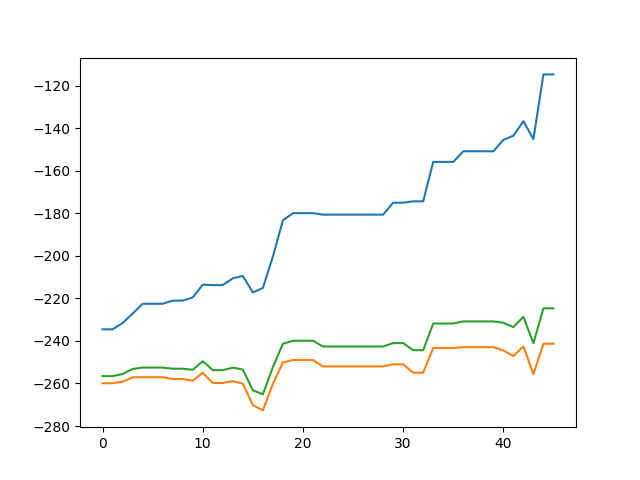

In [48]:
LLHs = []
BICs = []
AICs = []

%time
for graph in graphs:
    try:
        mle = pgm.graphical_gaussian_estimation(algo='scd',
                                                data=data,
                                                graph=graph)
        dist = mle.estimated.copy()

        LLHs.append(2 * dist.loglikelihood(data))
        
    except Exception as e:
        print e
        LLHs.append(float("nan"))
        BICs.append(LLHs[-1])
        AICs.append(LLHs[-1])
    else:
        BICs.append(LLHs[-1] - dist.nb_parameters * math.log(len(data.events)))
        AICs.append(LLHs[-1] - dist.nb_parameters * 2)

fig = pyplot.figure()
axes = fig.add_subplot(111)
axes.plot(LLHs)
axes.plot(BICs)
axes.plot(AICs)

In [49]:
aic = AICs.index(max(AICs))
bic = BICs.index(max(BICs))

<IPython.core.display.Javascript object>


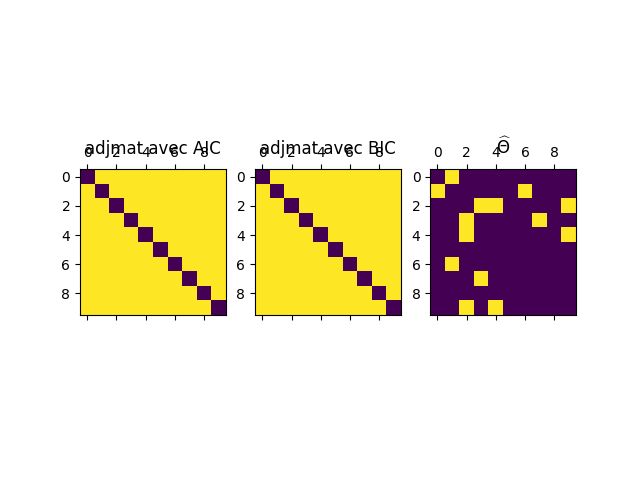

In [50]:
fig = pyplot.figure()
axes = graphs[aic].to_matrix().plot(axes = fig.add_subplot(131))
axes.set_title('adjmat avec AIC')
axes = graphs[bic].to_matrix().plot(axes = fig.add_subplot(132))
axes.set_title('adjmat avec BIC')
axes =  graph0.to_matrix().plot(axes = fig.add_subplot(133))
axes.set_title('$ \widehat \Theta$')

In [54]:
def TP(g0, g1):
    tp = 0
    for r in range(g0.nb_vertices):
        for c in range(g0.nb_vertices):
            if g0.has_edge(r, c) and g1.has_edge(r, c):
                tp += 1
    return tp

def TN(g0, g1):
    tn = 0
    for r in range(g0.nb_vertices):
        for c in range(g0.nb_vertices):
            if not g0.has_edge(r, c) and not g1.has_edge(r, c):
                tn += 1
    return tn

def FP(g0, g1):
    fp = 0
    for r in range(g0.nb_vertices):
        for c in range(g0.nb_vertices):
            if  g0.has_edge(r, c) and not g1.has_edge(r, c):
                fp += 1
    return fp

def FN(g0, g1):
    fn = 0
    for r in range(g0.nb_vertices):
        for c in range(g0.nb_vertices):
            if not g0.has_edge(r, c) and g1.has_edge(r, c):
                fn += 1
    return fn
tp, tn, fp, fn = TP(graph0, graph), TN(graph0, graph), FP(graph0, graph), FN(graph0, graph)
(tp, tn, fp, fn)

(14, 10, 0, 76)

In [56]:
TPs = []
TNs = []
FPs = []
FNs = []
for graph in graphs:
    TPs.append(TP(graph0, graph))
    TNs.append(TN(graph0, graph))
    FPs.append(FP(graph0, graph))
    FNs.append(FN(graph0, graph))

    

In [60]:
import hashlib
identifier = hashlib.md5(str(graph0)).hexdigest()


In [61]:
import math
with open(os.path.join('results', 'lasso.csv'), 'a') as filehandler:
    filehandler.write(','.join([identifier, str(K), str(LAMBDA), str(tp), str(tn), str(fp), str(fn)]) + '\n')